In [1]:
from __future__ import division

import bisect
import ctypes
import ctypes.util
import itertools
import datetime
import os
from optparse import OptionParser
import time
import re

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import spacepy.toolbox as tb
import spacepy.time as spt
import spacepy.datamodel as dm
import spacepy.pycdf as pycdf
# import spacepy.plot as spp
import pandas as pd
import seaborn as sns
import tqdm

%matplotlib inline

In [2]:
tagsfname = 'rbspa_int_ect-hope-PAtags-L3_20140106_v6.0.0.cdf'

In [3]:
with pycdf.CDF(tagsfname) as cdf:
    tb.dictree(cdf, verbose=1)

+
|____ESA_Volt_Elc_Cntr_e (spacepy.pycdf.Var (4181, 72))
|____ESA_Volt_Ion_Cntr_H (spacepy.pycdf.Var (3432, 72))
|____Epoch_Ele (spacepy.pycdf.Var (4181,))
|____Epoch_Ion (spacepy.pycdf.Var (3432,))
|____HOPE_DETECTOR (spacepy.pycdf.Var (5,))
|____HOPE_SECTOR (spacepy.pycdf.Var (16,))
|____PA_Ele (spacepy.pycdf.Var (4181, 5, 16, 72))
|____PA_Ion (spacepy.pycdf.Var (3432, 5, 16, 72))
|____PHI_Ele (spacepy.pycdf.Var (4181, 5, 16, 72))
|____PHI_Ion (spacepy.pycdf.Var (3432, 5, 16, 72))


In [4]:
L1fname = 'rbspa_ect-hope-sci-L1_20140106_v2.1.0.cdf'

In [5]:
with pycdf.CDF(L1fname) as cdf:
    tb.dictree(cdf, verbose=1)

+
|____Acquisition_Period (spacepy.pycdf.Var (7613,))
|____Cntr_Eclpse (spacepy.pycdf.Var (7613,))
|____Compression_Disable (spacepy.pycdf.Var (7613,))
|____Detector (spacepy.pycdf.Var (5,))
|____Detector_LABL (spacepy.pycdf.Var (5,))
|____EDAC_Address (spacepy.pycdf.Var (0, 128))
|____EDAC_LST_Epoch (spacepy.pycdf.Var (0,))
|____EDAC_LST_LABL (spacepy.pycdf.Var (128,))
|____EDAC_MET_sec (spacepy.pycdf.Var (0, 128))
|____EDAC_Type (spacepy.pycdf.Var (0, 128))
|____ESA_LogMeanVolt_Elc_TOF (spacepy.pycdf.Var (2197, 36))
|____ESA_LogMeanVolt_Ion_TOF (spacepy.pycdf.Var (2070, 36))
|____ESA_Parity_Err (spacepy.pycdf.Var (7613,))
|____ESA_Polarity (spacepy.pycdf.Var (7613,))
|____ESA_Sweep (spacepy.pycdf.Var (7613,))
|____ESA_Volt (spacepy.pycdf.Var (7613, 72))
|____ESA_Volt_Elc_Cntr_Bkg1 (spacepy.pycdf.Var (4181, 72))
|____ESA_Volt_Elc_Cntr_Bkg2 (spacepy.pycdf.Var (3627, 72))
|____ESA_Volt_Elc_Cntr_StartNoStops (spacepy.pycdf.Var (1904, 72))
|____ESA_Volt_Elc_Cntr_Starts (spacepy.pycdf.Var 

## Make up a DF for the PA tags and for the L1 counts and then merge them together

In [6]:
VToE = 7.0   # TODO get the real number
with pycdf.CDF(tagsfname) as cdf:
    energies = cdf['ESA_Volt_Ion_Cntr_H'][...] * VToE
    Epoch_Ion = pd.DatetimeIndex(cdf['Epoch_Ion'][...])
    HOPE_DETECTOR = cdf['HOPE_DETECTOR'][...]
    HOPE_SECTOR = cdf['HOPE_SECTOR'][...]
    PA_Ion = cdf['PA_Ion'][...]
    PHI_Ion = cdf['PHI_Ion'][...]
    
    n_t = len(Epoch_Ion)
    def make_df(e_ind, s_ind, p_ind):
        df = pd.DataFrame({'Energy':np.asarray([energies[:,e_ind]]).flatten(), 
                          'Detector':np.asarray([HOPE_DETECTOR[p_ind]]*n_t),
                           'Sector':np.asarray([HOPE_SECTOR[s_ind]]*n_t), 
                          'PA_Ion':PA_Ion[:, p_ind, s_ind, e_ind], 
                          'PHI_Ion':PHI_Ion[:, p_ind, s_ind, e_ind],
                          }, index=pd.DatetimeIndex(Epoch_Ion))
        return df
    
    df = []
    for e_ind, s_ind, p_ind in tqdm.tqdm(itertools.product(range(72), 
                                                           range(16), 
                                                           range(5)), total=72*16*5):
        df.append(make_df(e_ind, s_ind, p_ind))
    df = pd.concat(df)
    
# |____ESA_Volt_Elc_Cntr_e (spacepy.pycdf.Var (4181, 72))
# |____ESA_Volt_Ion_Cntr_H (spacepy.pycdf.Var (3432, 72))
# |____Epoch_Ele (spacepy.pycdf.Var (4181,))
# |____Epoch_Ion (spacepy.pycdf.Var (3432,))
# |____HOPE_DETECTOR (spacepy.pycdf.Var (5,))
# |____HOPE_SECTOR (spacepy.pycdf.Var (16,))
# |____PA_Ele (spacepy.pycdf.Var (4181, 5, 16, 72))
# |____PA_Ion (spacepy.pycdf.Var (3432, 5, 16, 72))
# |____PHI_Ele (spacepy.pycdf.Var (4181, 5, 16, 72))
# |____PHI_Ion (spacepy.pycdf.Var (3432, 5, 16, 72))

100%|██████████| 5760/5760 [00:12<00:00, 469.89it/s]


In [7]:
df['PA_bin5'] = pd.cut(df['PA_Ion'], range(0, 181, 5))
df['PHI_bin5'] = pd.cut(df['PHI_Ion'], range(0, 361, 5))

In [8]:
np.unique(df['PA_Ion'])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179], d

In [9]:
df.head()

,Detector,Energy,PA_Ion,PHI_Ion,Sector,PA_bin5,PHI_bin5
2014-01-06 00:00:13.056,1,0.98,87,283,1.0,"(85, 90]","(280, 285]"
2014-01-06 00:00:35.752,1,0.98,80,287,1.0,"(75, 80]","(285, 290]"
2014-01-06 00:01:21.145,1,0.98,64,284,1.0,"(60, 65]","(280, 285]"
2014-01-06 00:01:43.842,1,0.98,59,277,1.0,"(55, 60]","(275, 280]"
2014-01-06 00:02:06.539,1,0.98,57,268,1.0,"(55, 60]","(265, 270]"


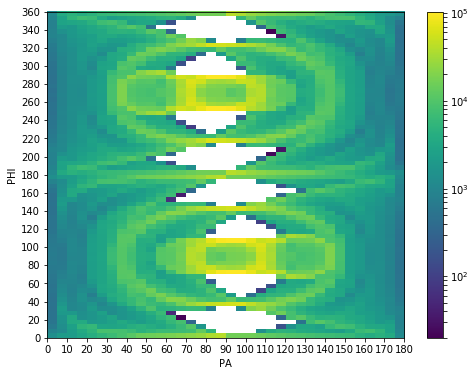

In [10]:
plt.figure(figsize=(8,6))
plt.hist2d(df['PA_Ion'], df['PHI_Ion'], (range(0, 181, 5), range(0, 361, 5)), 
           norm=LogNorm());
plt.colorbar()
plt.xlabel('PA')
plt.ylabel('PHI')
plt.xticks(range(0,181, 10))
plt.yticks(range(0,361, 20));

/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/colors.py:1015: RuntimeWarning: divide by zero encountered in log
  resdat -= np.log(vmin)
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/colors.py:1016: RuntimeWarning: divide by zero encountered in log
  resdat /= (np.log(vmax) - np.log(vmin))


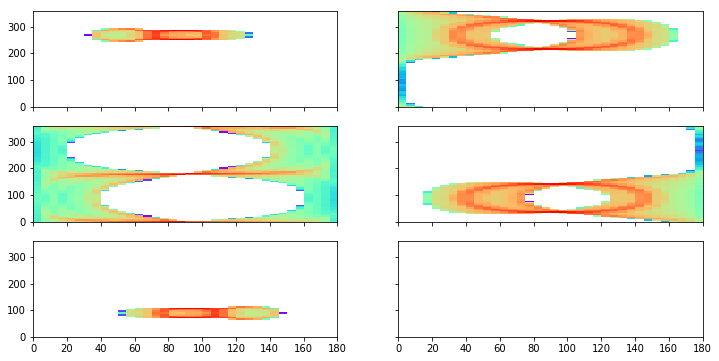

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,6), sharex=True, sharey=True)
ax = np.asarray(ax).flatten()

for i, a in enumerate(ax):
    a.hist2d(df['PA_Ion'].loc[df['Detector']==i+1], 
             df['PHI_Ion'].loc[df['Detector']==i+1], 
               (range(0, 181, 5), range(0, 361, 5)), 
               norm=LogNorm(), cmap=plt.cm.rainbow);
#     plt.colorbar()
#     plt.xlabel('PA')
#     plt.ylabel('PHI')
#     plt.xticks(range(0,181, 10))
#     plt.yticks(range(0,361, 20));

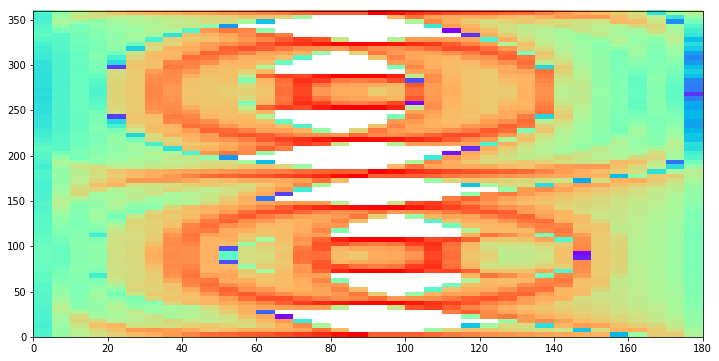

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6), sharex=True, sharey=True)
ax = np.asarray(ax).flatten()

for i, a in enumerate(range(5)):
    ax[0].hist2d(df['PA_Ion'].loc[df['Detector']==i+1], 
             df['PHI_Ion'].loc[df['Detector']==i+1], 
               (range(0, 181, 5), range(0, 361, 5)), 
               norm=LogNorm(), cmap=plt.cm.rainbow);
#     plt.colorbar()
#     plt.xlabel('PA')
#     plt.ylabel('PHI')
#     plt.xticks(range(0,181, 10))
#     plt.yticks(range(0,361, 20));

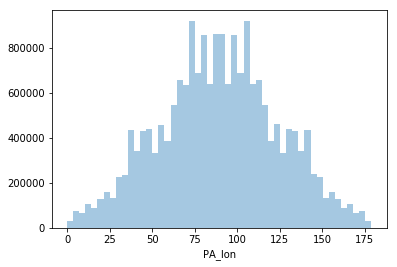

In [13]:
sns.distplot(df['PA_Ion'],norm_hist=False, kde=False)

In [14]:

# sns.distplot(df['PA_bin5'],norm_hist=False, kde=False)

PA_bin5
(0, 5]        AxesSubplot(0.125,0.125;0.775x0.755)
(5, 10]       AxesSubplot(0.125,0.125;0.775x0.755)
(10, 15]      AxesSubplot(0.125,0.125;0.775x0.755)
(15, 20]      AxesSubplot(0.125,0.125;0.775x0.755)
(20, 25]      AxesSubplot(0.125,0.125;0.775x0.755)
(25, 30]      AxesSubplot(0.125,0.125;0.775x0.755)
(30, 35]      AxesSubplot(0.125,0.125;0.775x0.755)
(35, 40]      AxesSubplot(0.125,0.125;0.775x0.755)
(40, 45]      AxesSubplot(0.125,0.125;0.775x0.755)
(45, 50]      AxesSubplot(0.125,0.125;0.775x0.755)
(50, 55]      AxesSubplot(0.125,0.125;0.775x0.755)
(55, 60]      AxesSubplot(0.125,0.125;0.775x0.755)
(60, 65]      AxesSubplot(0.125,0.125;0.775x0.755)
(65, 70]      AxesSubplot(0.125,0.125;0.775x0.755)
(70, 75]      AxesSubplot(0.125,0.125;0.775x0.755)
(75, 80]      AxesSubplot(0.125,0.125;0.775x0.755)
(80, 85]      AxesSubplot(0.125,0.125;0.775x0.755)
(85, 90]      AxesSubplot(0.125,0.125;0.775x0.755)
(90, 95]      AxesSubplot(0.125,0.125;0.775x0.755)
(95, 100]     AxesSubpl

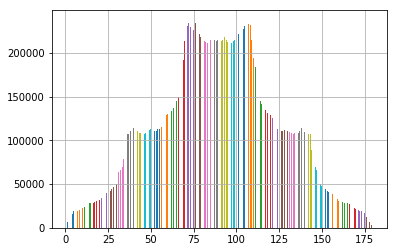

In [18]:
df.groupby('PA_bin5')['PA_Ion'].hist()